<script src='https://cdnjs.cloudflare.com/ajax/libs/mathjax/2.7.5/MathJax.js?config=TeX-MML-AM_CHTML' async></script>
<script type="text/x-mathjax-config">MathJax.Hub.Config({tex2jax: {inlineMath: [['$','$'], ['\\(','\\)']]}});</script>

# Unsymmetrical mixing

## Theory and equations

The Pitzer model includes an $^E\theta_{ij}$ term that accounts for 'unsymmetrical' interactions between pairs of ions with charges of the same sign but different magnitudes. From Pitzer (1991), Eq. B-15:

$$ ^E\theta_{ij} = \frac{z_iz_j}{4I} \Bigl[ J(x_{ij}) - \frac{1}{2} J(x_{ii}) - \frac{1}{2} J(x_{jj}) \Bigr] $$

where $z_i$ and $z_j$ are the charges on ions $i$ and $j$, $I$ is the ionic strength, and $x_{ij}$ is given by Pitzer (1991), Eq. B-14:

$$ x_{ij} = 6 z_i z_j A_\phi \sqrt{I} $$

where $A_\phi$ is the Debye-Hückel limiting law slope for the osmotic coefficient (Archer and Wang, 1990).

In the first equation above, the function $J(x)$ is defined by Pitzer (1991), Eq. B-13:

$$ J(x) = \frac{1}{x} \int_0^\infty \Bigl[ 1 + q + \frac{1}{2}q^2 - \exp(q) \Bigr] y^2 \mathrm{d}y $$

where, from Pitzer (1991), Eq. B-12:

$$ q = - \frac{x}{y} \exp(-y) $$

## Parameterisations

The $J(x)$ function has been parameterised, so that it can be evaluated more efficiently (from a computational perspective) than by using numerical integrations. However, several parameterisations have been proposed, with differing results.

Pitzer (1975) proposed two different approaches in his Eqs. 46 and 47:

$$ J_{\mathrm{P}46}(x) = -\frac{1}{6}x^2 (\ln{x}) \exp(-10 x^2) + \Bigl( \sum_{k=1}^{6} C_k x^{-k} \Bigr) $$

$$ J_{\mathrm{P}47}(x) = x [C_0 + C_1 x^{-C_2} \exp(-C_3 x^{C_4})]^{-1} $$

The $C_k$ coefficients take the following values (Pitzer 1975, Table III):

<table><tr>
    
<td>$k$</td><td>$J_{\mathrm{P}46}$</td><td>$J_{\mathrm{P}47}$</td>

</tr><tr><td>$1$</td> <td>$4.118$</td> <td>$4.581$</td>
</tr><tr><td>$2$</td> <td>$7.247$</td> <td>$0.7237$</td>
</tr><tr><td>$3$</td> <td>$-4.408$</td> <td>$0.0120$</td>
</tr><tr><td>$4$</td> <td>$1.837$</td> <td>$0.528$</td>
</tr><tr><td>$5$</td> <td>$-0.251$</td> <td>-</td>
</tr><tr><td>$6$</td> <td>$0.0164$</td> <td>-</td>

</tr></table>

It is noted that $J_{\mathrm{P}46}$ is appropriate to low $x$ (from 0.1 to 80) whereas $J_{\mathrm{P}47}$ may work better for larger $x$, and that the accuracy of both (c. 2%) is sufficient for the purpose of the model.

Pitzer (1991) also describes "Harvie's method" (henceforth $J_\mathrm{H}$), which is more accurate, and which uses two Chebyshev polynomial approximations (Eqs. B-21 to B-30 and Table B-1).

## Intercomparison

**pytzer** contains implementations of all three parameterised approaches described above. First, we will create an implementation of the "exact" calculation (using numerical integration), and compare all of the $J$ functions.

<IPython.core.display.Javascript object>


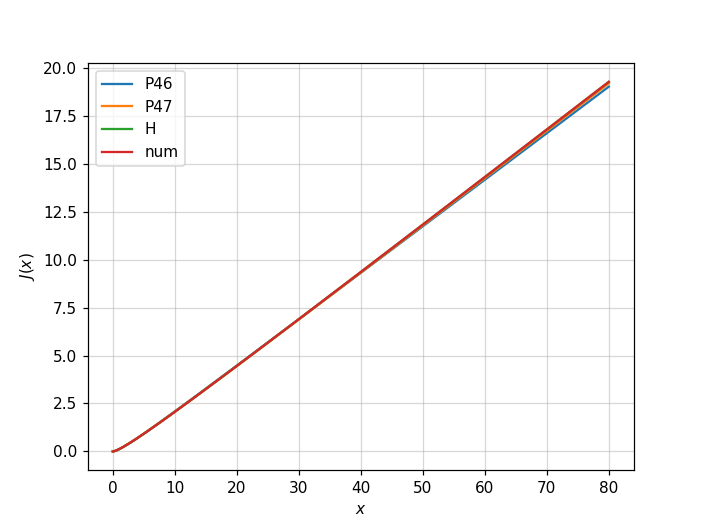

In [2]:
# Import packages
import pytzer as pz
import numpy as np
from matplotlib import pyplot as plt
%matplotlib notebook

# Generate x array, evenly spaced in sqrt(x)
sqx = np.linspace(0.001,np.sqrt(80),1000)
x = sqx**2

# Do numerical integral
J_num = pz.jfuncs.numint(x)

# Evaluate parameterisations
J_P46 = pz.jfuncs.P75_eq46(x)
J_P47 = pz.jfuncs.P75_eq47(x)
J_H   = pz.jfuncs.Harvie  (x)

# Collect for convenience
Js = [J_P46, J_P47, J_H, J_num]
Jnames = ['P46','P47','H','num']

# Plot results
fig,ax = plt.subplots()
for i,J in enumerate(Js):
    ax.plot(x,J, label=Jnames[i])
ax.grid(alpha=0.5)
ax.set_xlabel('$x$')
ax.set_ylabel('$J(x)$')
ax.legend();

To first order, all of the algorithms return similar results over this range of $x$. To see the differences more clearly, we can look at the difference between each parameterisation and the numerical integration approach:

<IPython.core.display.Javascript object>


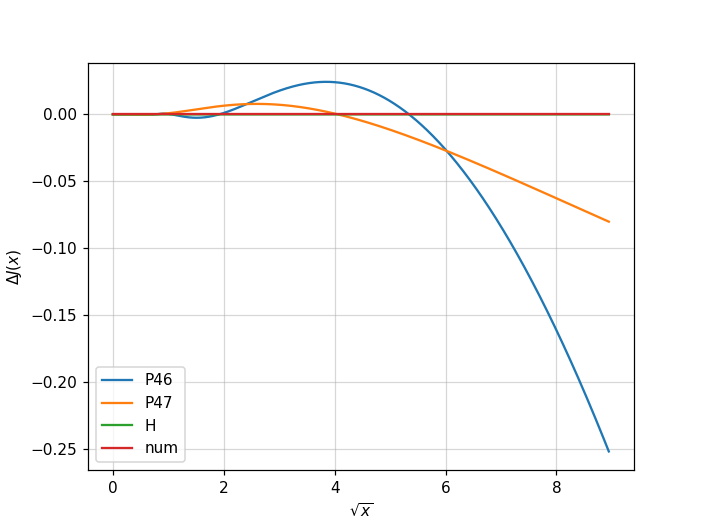

In [3]:
# Show differences between parameterisations and numerical integral
fig,ax = plt.subplots()
for i,J in enumerate(Js):
    ax.plot(sqx,J - J_num, label=Jnames[i])
ax.grid(alpha=0.5)
ax.set_xlabel('$\sqrt{x}$')
ax.set_ylabel('$\Delta J(x)$')
ax.legend();

Now we can see clearly the much greater accuracy of Harvie's method relative to the equations of Pitzer (1975). Indeed, Harvie's method appears to be almost 10 orders of magnitude more accurate:

<IPython.core.display.Javascript object>


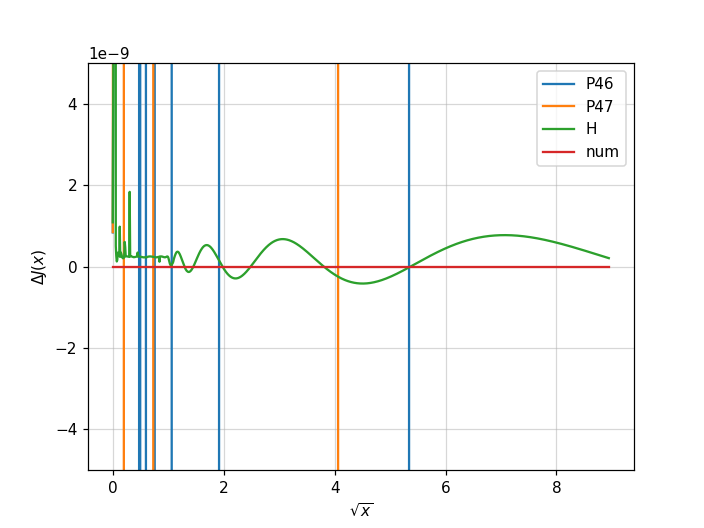

In [4]:
# As above but with zoomed-in y-axis
fig,ax = plt.subplots()
for i,J in enumerate(Js):
    ax.plot(sqx,J - J_num, label=Jnames[i])
ax.grid(alpha=0.5)
ax.set_xlabel('$\sqrt{x}$')
ax.set_ylabel('$\Delta J(x)$')
ax.set_ylim([-5e-9,5e-9])
ax.legend();

However, the implementation of Harvie's method is not suitable for automatic differentiation, as is required by **pytzer**, whereas the other equations are suitable.

## Improvements

Somewhat surprisingly, the equations of Pitzer (1975) can be substantially improved by simply refitting their $C_k$ coefficients.

In [5]:
from scipy.optimize import least_squares

# Define P46 equation
def P46fx(C,x):
    J = np.zeros_like(x)
    for k,Ck in enumerate(C):
        J += Ck * x**-(k+1)
    return 1/J - x**2 * np.log(x) * np.exp(-10 * x**2) / 6

# Re-fit coefficients
P46fit = least_squares(lambda C: P46fx(C,x) - J_num, [4.118,7.247,-4.408,1.837,-0.251,0.0164])

# Show newly fitted values for P46
print(P46fit['x'])

[  4.0354773    9.88693464 -16.50967185  15.1212098   -4.01961191
   0.29481762]


In [6]:
# Define P47 equation
P47fx = lambda C,x: x/(C[0] + C[1]*x**-C[2] * np.exp(-C[3]*x**C[4]))

# Re-fit coefficients
P47fit = least_squares(lambda C: P47fx(C,x) - J_num, [4,4.581,0.7237,0.0120,0.528])

# Show newly fitted values for P47
print(P47fit['x'])

[4.01547754 5.19195495 0.65347976 0.12747938 0.40991769]


<IPython.core.display.Javascript object>


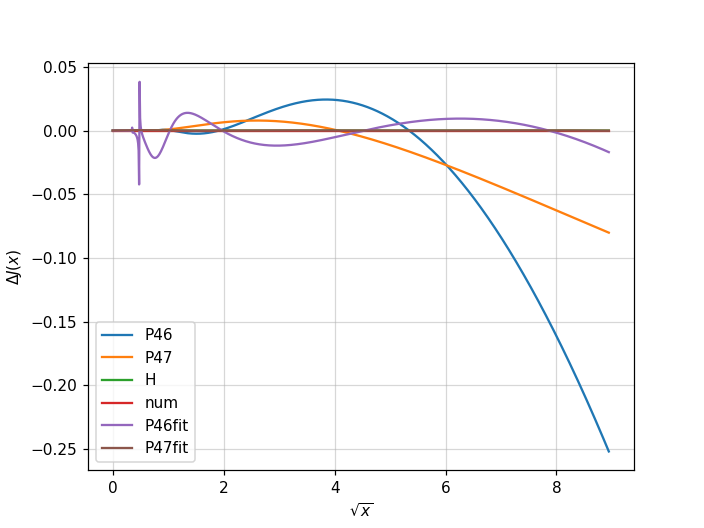

In [7]:
# Calculate refitted J(X)
J_P46fit = P46fx(P46fit['x'],x)
J_P47fit = P47fx(P47fit['x'],x)

# Add to lists
Js = [J_P46, J_P47, J_H, J_num, J_P46fit, J_P47fit]
Jnames = ['P46','P47','H','num','P46fit','P47fit']

# Plot results
fig,ax = plt.subplots()
for i,J in enumerate(Js):
    ax.plot(sqx,J - J_num, label=Jnames[i])
ax.grid(alpha=0.5)
ax.set_xlabel('$\sqrt{x}$')
ax.set_ylabel('$\Delta J(x)$')
ax.legend();

The refits have improved the average behaviour (across all $x$) for both Pitzer (1975) parameterisations.

The P46 refit now misbehaves at low $x$, so this is probably not useful improvement. But the P47 refit has much better performance across the entire $x$ range. Zooming in on the y-axis again:

<IPython.core.display.Javascript object>


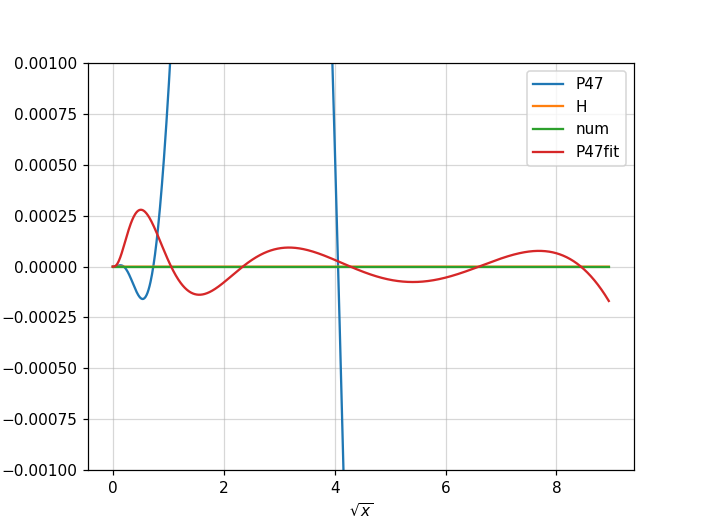

In [8]:
# Examine P47 refit
fig,ax = plt.subplots()
for i,J in enumerate(Js):
    if Jnames[i] != 'P46' and Jnames[i] != 'P46fit':
        ax.plot(sqx,J - J_num, label=Jnames[i])
ax.grid(alpha=0.5)
ax.set_xlabel('$\sqrt{x}$')
ax.set_ylabel('$\Delta J(x)$')
ax.set_ylim([-1e-3,1e-3])
ax.legend();

Although the refit P47 is still nowhere near as accurate as Harvie's method, it is substantially more accurate than using the original coefficients, with the exception of $x < 1$. If desired, the refit performance can be improved further by adding in a couple of extra terms:

$$ J_{\mathrm{P}47}^*(x) = x [C_0 + C_1 x^{-C_2} \exp(-C_3 x^{C_4}) + C_5 x + C_6 \ln{x}]^{-1} $$

In [9]:
# Define souped-up P47 equation
P47fx2 = lambda C,x: x/(C[0] + C[1]*x**-C[2] * np.exp(-C[3]*x**C[4]) + C[5]*x + C[6]*np.log(x))

# Re-fit coefficients
P47fit2 = least_squares(lambda C: P47fx2(C,x) - J_num, [4,4.581,0.7237,0.0120,0.528,0,0])

# Show newly fitted values for souped-up P47
print(P47fit2['x'])

[ 4.43345682e+00  4.69842129e+00  6.88528261e-01  1.22474061e-01
  6.06798538e-01  1.54971531e-04 -7.59924290e-02]


<IPython.core.display.Javascript object>


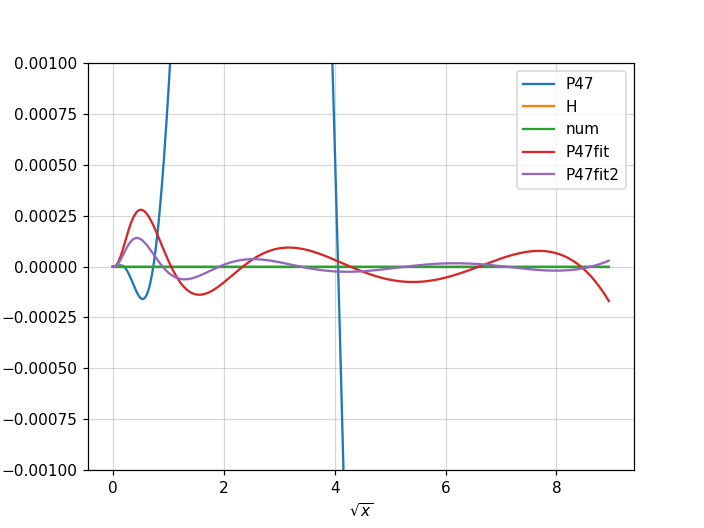

In [10]:
# Calculate refitted J(X) and add to list
J_P47fit2 = P47fx2(P47fit2['x'],x)
Js = [J_P46, J_P47, J_H, J_num, J_P46fit, J_P47fit,J_P47fit2]
Jnames = ['P46','P47','H','num','P46fit','P47fit','P47fit2']

# Examine modified P47 refit
fig,ax = plt.subplots()
for i,J in enumerate(Js):
    if Jnames[i] != 'P46' and Jnames[i] != 'P46fit':
        ax.plot(sqx,J - J_num, label=Jnames[i])
ax.grid(alpha=0.5)
ax.set_xlabel('$\sqrt{x}$')
ax.set_ylabel('$\Delta J(x)$')
ax.set_ylim([-1e-3,1e-3])
ax.legend();

The $J_{\mathrm{P}47}^*$ function performs no worse than the original P47 fit where $x < 1$, and is far superior for all higher $x$.